In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [8]:
df = pd.read_csv('consumer_complaints.csv')

/Users/cablej/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [9]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
date_received                   555957 non-null object
product                         555957 non-null object
sub_product                     397635 non-null object
issue                           555957 non-null object
sub_issue                       212622 non-null object
consumer_complaint_narrative    66806 non-null object
company_public_response         85124 non-null object
company                         555957 non-null object
state                           551070 non-null object
zipcode                         551452 non-null object
tags                            77959 non-null object
consumer_consent_provided       123458 non-null object
submitted_via                   555957 non-null object
date_sent_to_company            555957 non-null object
company_response_to_consumer    555957 non-null object
timely_response                 555957 non-null object
consumer_dis

In [13]:
df.product.value_counts()

AttributeError: 'function' object has no attribute 'value_counts'

In [14]:
df.loc[df['product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.product != 'Other financial service']

KeyError: True

In [15]:
df['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
                                                                title='Number complaints in each product')

In [19]:
def print_plot(index):
    example = df[df.index == index][['consumer_complaint_narrative', 'product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [20]:
print_plot(10)

nan
Product: Debt collection


In [21]:
print_plot(100)

nan
Product: Money transfers


In [23]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(clean_text)

AttributeError: 'float' object has no attribute 'lower'

In [12]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

In [13]:
print_plot(10)

account reported twice credit report asked eplanation credit bureaus got response furthermore account never paid late faithfully paying account creditor late payments fi error please since eperian couldnt help
Product: Credit reporting, credit repair services, or other personal consumer reports


In [14]:
print_plot(100)

predatory lending complaint may concern writing file complaint ecmc predatory lending practices mailed two certified letters first letter debt validation letter via cert number second letter titled notice estoppel via cert number please see attachments b started credit restoration certified credit counselor  come find total  collection agencies trying collect school loan ignorance forced make payments one agency titled collected weekly paycheck withdraw paycheck caused real hardship choice make payments couldnt stay employed mailed debt validation letter via mail cert second letter titled notice estoppel via cert # finally stopped collecting second letter almost  months paid payments collecting  see attachment c went proper channels asking human resources provide order payments see ecmc mentioned within order see attachment e clearly states assistant company collect debt ecmc new loan number ecmc created two loan numbers trying collect two payments one loan owed never announced ecmc wo

In [15]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 141712 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (361574, 250)


In [17]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (361574, 13)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(325416, 250) (325416, 13)
(36158, 250) (36158, 13)


In [20]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 13)                1313      
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 292874 samples, validate on 32542 samples
Epoch 1/5
292874/292874 [==============================] - 1266s 4ms/step - loss: 0.8802 - acc: 0.7211 - val_loss: 0.6457 - val_acc: 0.7819
Epoch 2/5
292874/292874 [==============================] - 1246s 4ms/step - loss: 0.5814 - acc: 0.7996 - val_loss: 0.5529 - val_acc: 0.8074
Epoch 3/5
292874/292874 [==============================] - 1248s 4ms/step - loss: 0.5107 - acc: 0.8204 - val_loss: 0.5307 - val_acc: 0.8159
Epoch 4/5
292874/292874 [==============================] - 1255s 4ms/step - loss: 0.4615 - acc: 0.8398 - val_loss: 0.5199 - val_acc: 0.8244
Epoch 5/5
292874/292874 [==============================] - 1235s 4ms/step - loss: 0.4206 - acc: 0.8555 - val_loss: 0.5285 - val_acc: 0.8238


In [22]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

36158/36158 [==============================] - 38s 1ms/step
Test set
  Loss: 0.519
  Accuracy: 0.824


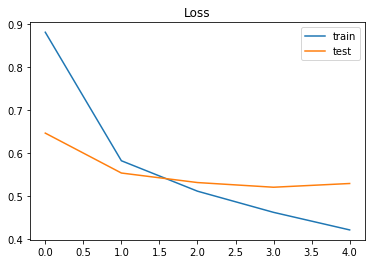

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

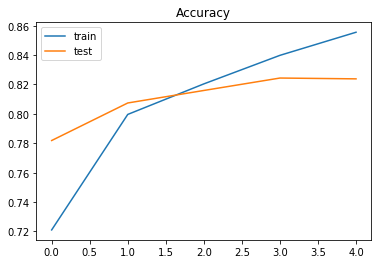

In [24]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

Test with a new complaint.

In [39]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[1.5803229e-02 2.3755017e-03 5.1062729e-04 5.3740919e-01 3.5682529e-01
  8.5910626e-02 3.0194962e-04 2.5151852e-05 3.9089144e-05 1.0010027e-04
  5.1000190e-04 1.3226915e-04 5.6953013e-05]] Credit card or prepaid card
